Starting with an accuracy of .77, let's try iteration two: this time with three categories.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPool1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy
from keras import initializers, regularizers, constraints, optimizers, layers

import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

In [57]:
parody = pd.read_csv('../data/processed/parody.csv')
parody.drop(['Unnamed: 0', 'article_link', 'is_parody'], axis=1, inplace=True)

In [58]:
clickbait = open('../data/raw/clickbait_data', mode='r')
clickbait = [line for line in clickbait]
clickbait = pd.DataFrame({"headline": clickbait})
clickbait = clickbait[clickbait['headline'] != '\n']
clickbait = clickbait['headline'].str.replace('\n', '')
clickbait = pd.DataFrame(clickbait)
clickbait.dropna(inplace=True)
clickbait.headline = clickbait.headline.str.lower()
clickbait.head()

,headline
0,should i get bings
2,which tv female friend group do you belong in
4,"the new ""star wars: the force awakens"" trailer..."
6,"this vine of new york on ""celebrity big brothe..."
8,a couple did a stunning photo shoot with their...


In [59]:
real = open('../data/raw/non_clickbait_data', mode='r')
real = [line for line in real]
real = pd.DataFrame({"headline": real})
real = real[real['headline'] != '\n']
real = real['headline'].str.replace('\n', '')
real = pd.DataFrame(real)
real.dropna(inplace=True)
real.headline = real.headline.str.lower()
real.head()

,headline
0,bill changing credit card rules is sent to oba...
1,"in hollywood, the easy-money generation toughe..."
2,1700 runners still unaccounted for in uk's lak...
4,yankees pitchers trade fielding drills for put...
5,large earthquake rattles indonesia; seventh in...


In [60]:
parody.shape, clickbait.shape, real.shape

((11725, 1), (15999, 1), (16001, 1))

In [61]:
import string
table = str.maketrans('', '', string.punctuation)

In [62]:
real.headline = real.headline.str.translate(table)
parody.headline = parody.headline.str.translate(table)
clickbait.headline = clickbait.headline.str.translate(table)

In [63]:
real['real'] = 1
real['parody'] = 0
real['clickbait'] = 0

In [64]:
parody['real'] = 0
parody['parody'] = 1
parody['clickbait'] = 0

In [65]:
clickbait['real'] = 0
clickbait['parody'] = 0
clickbait['clickbait'] = 1

In [66]:
seed = 7

real = real.sample(n=11725, random_state=seed)
clickbait = clickbait.sample(n=11725, random_state=seed)

In [67]:
parody.shape, clickbait.shape, real.shape

((11725, 4), (11725, 4), (11725, 4))

In [68]:
df = pd.concat([real, parody, clickbait])
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,headline,real,parody,clickbait
0,13 very honest confessions from people having ...,0,0,1
1,palestinians stop paying israeli hospitals for...,1,0,0
2,kushner i did not collude but i pretty much ha...,0,1,0
3,naomi campbell posed nude for a magazine and i...,0,0,1
4,3 ways to make spaghetti squash pasta,0,0,1


In [69]:
df.shape

(35175, 4)

In [70]:
train_size = int(35175 * .90)

In [71]:
X_train = df.iloc[:train_size, 0]
X_test = df.iloc[train_size:, 0]
y_train = df.iloc[:train_size, 1:]
y_test = df.iloc[train_size:, 1:]

In [72]:
X_train.head()

0    13 very honest confessions from people having ...
1    palestinians stop paying israeli hospitals for...
2    kushner i did not collude but i pretty much ha...
3    naomi campbell posed nude for a magazine and i...
4                3 ways to make spaghetti squash pasta
Name: headline, dtype: object

In [73]:
y_train.head()

,real,parody,clickbait
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,0,1


In [74]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [75]:
total_word_counts = [len(headline) for headline in list_tokenized_train]

(array([2.300e+01, 1.060e+02, 3.220e+02, 9.080e+02, 1.813e+03, 7.094e+03,
        4.435e+03, 4.183e+03, 3.720e+03, 2.935e+03, 3.649e+03, 9.730e+02,
        6.460e+02, 3.330e+02, 2.530e+02, 1.960e+02, 3.000e+01, 1.700e+01,
        1.100e+01, 2.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
        13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. , 25.2,
        26.4, 27.6, 28.8, 30. , 31.2, 32.4, 33.6, 34.8, 36. ]),
 <a list of 30 Patch objects>)

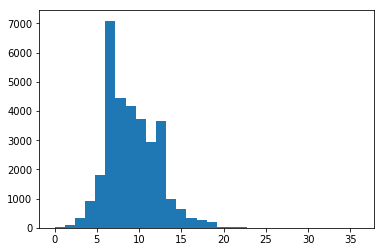

In [76]:
plt.hist(total_word_counts, bins=30)

In [77]:
maxlen = 18
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_t = np.array(y_train)
y_te = np.array(y_test)

In [78]:
tokens = tokenizer.sequences_to_texts(list_tokenized_train) + tokenizer.sequences_to_texts(list_tokenized_test)
tokens = [t.split(' ') for t in tokens]

In [83]:
model = Word2Vec(tokens, size=100, window=5, min_count=1, workers=4)
model.train(tokens, total_examples=model.corpus_count, epochs=10)

(2787885, 3171380)

In [84]:
embeddings = model.wv
keras_embedding = embeddings.get_keras_embedding()

In [101]:
model = Sequential()
model.add(keras_embedding)
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(3, activation='softmax'))
adam = optimizers.Nadam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          19264     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
__________

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, verbose=1)
callbacks_list = [early_stopping]

In [ ]:
batch_size = 256
num_epochs = 100

In [ ]:
hist = model.fit(X_t, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

In [ ]:
model.evaluate(X_te, y_test)

In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(keras_embedding)
model.add(Conv1D(64, 18, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(3, activation='softmax'))
adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

In [ ]:
hist = model.fit(X_t, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [85]:
def news_conv_model(X_train, y_train, x_val, y_val, params):

    # define base model
    model = Sequential()
    model.add(keras_embedding)
    model.add(Conv1D(64, 3, activation=params['activation'], padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 3, activation=params['activation'], padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 3, activation=params['activation'], padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(params['dropout']))
    model.add(Dense(32, activation=params['activation'], kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=params['optimizer'](),
        metrics=['accuracy'])

    # fit model
    hist = model.fit(
        X_train, y_train, 
        batch_size=params['batch_size'], 
        epochs=params['epochs'], 
        validation_split=0.1, 
        shuffle=True, 
        verbose=0)

    return hist, model

In [41]:
p = {'lr': (0.1, 0.01, 0.001),
    'first_neuron':[4, 8, 16, 32, 64],
    'filter_size':[3, 4, 5],
    'batch_size': (16, 128, 512),
    'epochs': [25, 75, 150],
    'dropout': (0, 0.5, 0.8),
    'optimizer': [optimizers.Adam, optimizers.Nadam, optimizers.RMSprop],
    'activation':['relu', 'elu']}

In [97]:
p = {'lr': [0.1, 0.001],
    'first_neuron':[4, 8],
    'filter_size':[3, 4],
    'batch_size': [16, 32],
    'epochs': [5,10],
    'dropout': (0, 0.5),
    'optimizer': [optimizers.Adam],
    'activation':['relu']}

In [91]:
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

In [92]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

# Keras items
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy

In [93]:
type(y_train)

pandas.core.frame.DataFrame

In [98]:
t = ta.Scan(x=X_t,
            y=np.array(y_train),
            x_val=X_te,
            y_val=np.array(y_test),
            model=news_conv_model,
            params=p,
            dataset_name='news_nlp')

IndexError: tuple index out of range